In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

# Define your paths (change these if your files are in a different folder)
CONDITIONS_PATH = 'release_conditions.json'
EVIDENCES_PATH = 'release_evidences.json'
TRAIN_PATH = 'release_train_patients' # or .csv if you extracted it

# Load the dictionaries
with open(CONDITIONS_PATH, 'r') as f:
    conditions = json.load(f)

with open(EVIDENCES_PATH, 'r') as f:
    evidences = json.load(f)

print(f"Total Conditions (Diseases to predict): {len(conditions)}")
print(f"Total Evidences (Symptoms/Risk Factors): {len(evidences)}")

Total Conditions (Diseases to predict): 49
Total Evidences (Symptoms/Risk Factors): 223


C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\1078920861.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=severities, palette='Reds_r')


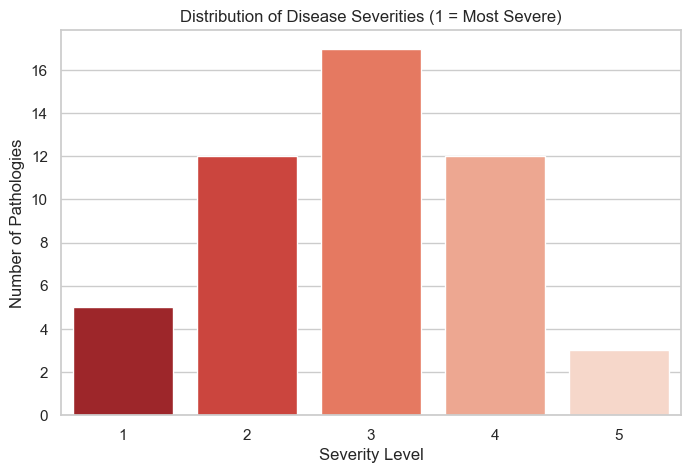

In [3]:
# --- Task 1: Distribution of Disease Severity ---
# In DDXPlus, lower severity numbers indicate higher medical urgency (e.g., 1 = Emergency)
severities = [details.get('severity') for code, details in conditions.items() if 'severity' in details]

plt.figure(figsize=(8, 5))
sns.countplot(x=severities, palette='Reds_r')
plt.title('Distribution of Disease Severities (1 = Most Severe)')
plt.xlabel('Severity Level')
plt.ylabel('Number of Pathologies')
plt.show()


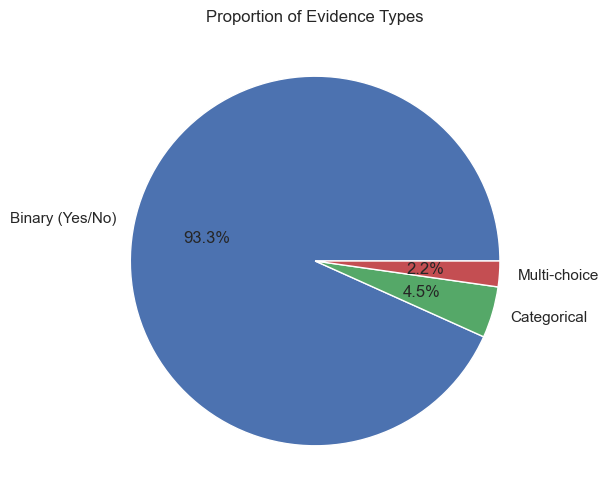

In [4]:

# --- Task 2: Evidence Types (Binary vs Categorical) ---
data_types = [details.get('data_type') for code, details in evidences.items() if 'data_type' in details]
type_counts = pd.Series(data_types).value_counts()

# DDXPlus uses 'B' for Binary, 'C' for Categorical, 'M' for Multi-choice
label_map = {'B': 'Binary (Yes/No)', 'C': 'Categorical', 'M': 'Multi-choice'}
labels = [label_map.get(val, val) for val in type_counts.index]

plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=labels, autopct='%1.1f%%', colors=['#4C72B0', '#55A868', '#C44E52'])
plt.title('Proportion of Evidence Types')
plt.show()


In [5]:

# --- Task 3: Peek at the Patient Records ---
print("Loading a 5-row sample of the patient dataset...")
# Note: pandas can read directly from the zip file using compression='zip'
# If you already extracted the .csv, simply remove the compression argument.
df_sample = pd.read_csv(TRAIN_PATH, nrows=5) 
display(df_sample.head())



Loading a 5-row sample of the patient dataset...


,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91
1,21,"[['HIV (initial infection)', 0.518950056440760...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",F,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",M,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201


In [6]:
# Let's specifically look at the messy 'EVIDENCES' column for the first patient
print("\n--- Deep Dive: The EVIDENCES column for Patient 0 ---")
raw_evidence_string = df_sample['EVIDENCES'].iloc[0]
print(f"Raw string: \n{raw_evidence_string}")
print(f"\nData type in pandas: {type(raw_evidence_string)}")


--- Deep Dive: The EVIDENCES column for Patient 0 ---
Raw string: 
['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_V_167', 'E_56_@_4', 'E_57_@_V_123', 'E_58_@_3', 'E_59_@_3', 'E_77', 'E_79', 'E_91', 'E_97', 'E_201', 'E_204_@_V_10', 'E_222']

Data type in pandas: <class 'str'>


In [7]:
import ast

# 1. Fix the string issue using ast.literal_eval
# This safely evaluates the string and turns it back into a real Python list
patient_0_evidences_str = df_sample['EVIDENCES'].iloc[0]
patient_0_evidences_list = ast.literal_eval(patient_0_evidences_str)

print(f"Parsed type: {type(patient_0_evidences_list)}")
print(f"Number of symptoms/features for Patient 0: {len(patient_0_evidences_list)}\n")

# 2. Let's translate these codes into English!
print(f"--- PATIENT 0 DIAGNOSIS: {df_sample['PATHOLOGY'].iloc[0]} ---")
print("Symptoms and History:")

for item in patient_0_evidences_list:
    # Handle the complex categorical format like 'E_54_@_V_161'
    if '_@_' in item:
        code, value = item.split('_@_')
        symptom_name = evidences[code]['name']
        
        # Check if it's a value code (V_xxx) or a direct number (like a pain scale)
        if value.startswith('V_'):
            # The JSON stores valid values inside a 'value_meaning' dictionary
            value_meaning = evidences[code].get('value_meaning', {})
            actual_value = value_meaning.get(value, value)
            print(f"- {symptom_name}: {actual_value}")
        else:
            print(f"- {symptom_name}: {value}")
            
    # Handle the simple binary format like 'E_48'
    else:
        symptom_name = evidences[item]['name']
        print(f"- {symptom_name}: Yes")

Parsed type: <class 'list'>
Number of symptoms/features for Patient 0: 19

--- PATIENT 0 DIAGNOSIS: URTI ---
Symptoms and History:
- E_48: Yes
- E_50: Yes
- E_53: Yes
- E_54: {'fr': 'sensible', 'en': 'sensitive'}
- E_54: {'fr': 'une lourdeur', 'en': 'heavy'}
- E_55: {'fr': 'front', 'en': 'forehead'}
- E_55: {'fr': 'joue(D)', 'en': 'cheek(R)'}
- E_55: {'fr': 'tempe(G)', 'en': 'temple(L)'}
- E_56: 4
- E_57: {'fr': 'nulle part', 'en': 'nowhere'}
- E_58: 3
- E_59: 3
- E_77: Yes
- E_79: Yes
- E_91: Yes
- E_97: Yes
- E_201: Yes
- E_204: {'fr': 'N', 'en': 'N'}
- E_222: Yes


In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

class DDXPreprocessor:
    def __init__(self, evidences_dict):
        self.vocab = {}
        self.inverse_vocab = {}
        self.evidences = evidences_dict
        self._build_vocab()
        
    def _build_vocab(self):
        """Creates a unique index for every possible symptom and its values."""
        idx = 0
        for code, details in self.evidences.items():
            data_type = details.get('data_type', 'B')
            
            if data_type == 'B': # Binary (Yes/No)
                self.vocab[code] = idx
                self.inverse_vocab[idx] = code
                idx += 1
            else: # Categorical or Multichoice (e.g., Pain scale, Location)
                possible_values = details.get('possible-values', [])
                for val in possible_values:
                    token = f"{code}_@_{val}"
                    self.vocab[token] = idx
                    self.inverse_vocab[idx] = token
                    idx += 1
                    
    def transform_X(self, evidence_lists):
        """Converts lists of symptom strings into a binary numpy matrix."""
        # Using int8 saves 8x RAM compared to standard int64!
        X = np.zeros((len(evidence_lists), len(self.vocab)), dtype=np.int8)
        
        for i, patient_evidences in enumerate(evidence_lists):
            # Remember to parse the string to a list first
            if isinstance(patient_evidences, str):
                patient_evidences = ast.literal_eval(patient_evidences)
                
            for item in patient_evidences:
                if item in self.vocab:
                    col_idx = self.vocab[item]
                    X[i, col_idx] = 1
        return X

# --- 1. Load a larger subset for training (10,000 rows) ---
print("Loading 10,000 rows for processing...")
df_train = pd.read_csv(TRAIN_PATH, nrows=10000)

# --- 2. Initialize Preprocessor and create X matrix ---
print("Building Feature Matrix (X)...")
preprocessor = DDXPreprocessor(evidences)
X = preprocessor.transform_X(df_train['EVIDENCES'])

print(f"Total Unique Features (Vocabulary Size): {len(preprocessor.vocab)}")
print(f"Shape of X: {X.shape} (Patients, Features)")

# --- 3. Create y vector (Target Labels) ---
print("Encoding Target Variable (y)...")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['PATHOLOGY'])

print(f"Shape of y: {y.shape}")
print(f"Total Unique Diseases in this subset: {len(np.unique(y))}")

Loading 10,000 rows for processing...
Building Feature Matrix (X)...
Total Unique Features (Vocabulary Size): 972
Shape of X: (10000, 972) (Patients, Features)
Encoding Target Variable (y)...
Shape of y: (10000,)
Total Unique Diseases in this subset: 49


In [9]:
# --- Cell 5: Dataset Info & Null Counts ---
print("--- DATASET INFO ---")
df_train.info()

print("\n--- NULL VALUE COUNTS ---")
print(df_train.isnull().sum())

--- DATASET INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   AGE                     10000 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  10000 non-null  object
 2   SEX                     10000 non-null  object
 3   PATHOLOGY               10000 non-null  object
 4   EVIDENCES               10000 non-null  object
 5   INITIAL_EVIDENCE        10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB

--- NULL VALUE COUNTS ---
AGE                       0
DIFFERENTIAL_DIAGNOSIS    0
SEX                       0
PATHOLOGY                 0
EVIDENCES                 0
INITIAL_EVIDENCE          0
dtype: int64


In [10]:
# --- Cell 6: Summary Statistics for Numerical Data ---
print("--- AGE SUMMARY STATISTICS ---")
display(df_train[['AGE']].describe())

--- AGE SUMMARY STATISTICS ---


,AGE
count,10000.000000
mean,39.166800
std,22.762315
min,0.000000
25%,22.000000
50%,38.000000
75%,56.000000
max,109.000000


In [11]:
# --- Cell 7: Value Counts for Categorical Columns ---
print("--- GENDER DISTRIBUTION (%) ---")
print(df_train['SEX'].value_counts(normalize=True) * 100)

print("\n--- TOP 10 INITIAL EVIDENCES (Chief Complaints) ---")
# Translate the raw code to English using our dictionary
initial_evidences = df_train['INITIAL_EVIDENCE'].map(
    lambda x: evidences[x]['name'] if x in evidences else x
)
print(initial_evidences.value_counts().head(10))

--- GENDER DISTRIBUTION (%) ---
SEX
F    50.79
M    49.21
Name: proportion, dtype: float64

--- TOP 10 INITIAL EVIDENCES (Chief Complaints) ---
INITIAL_EVIDENCE
E_53     1715
E_66      811
E_201     761
E_181     503
E_91      355
E_129     253
E_45      247
E_151     243
E_194     240
E_77      190
Name: count, dtype: int64


C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\1449864880.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_diseases.values, y=top_diseases.index, ax=axes[1], palette='viridis')


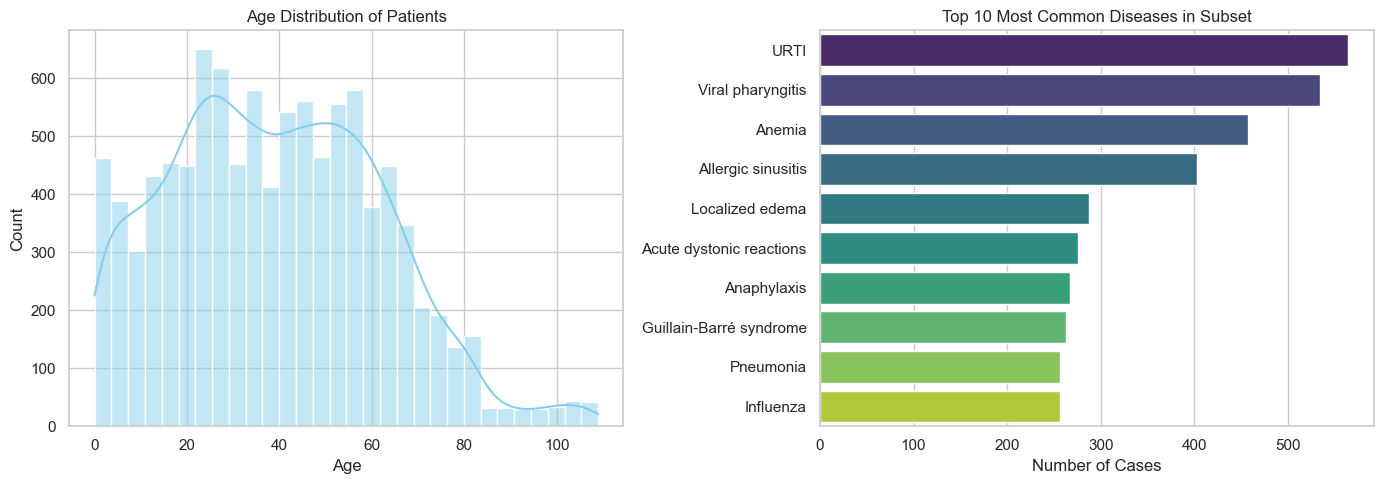

In [12]:
# --- Cell 8: Visualizations ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Age Distribution
sns.histplot(df_train['AGE'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution of Patients')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Plot 2: Top 10 Most Common Diseases in Sample
top_diseases = df_train['PATHOLOGY'].value_counts().head(10)
sns.barplot(x=top_diseases.values, y=top_diseases.index, ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Most Common Diseases in Subset')
axes[1].set_xlabel('Number of Cases')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [13]:
# --- 1. Encode SEX to Binary ---
# M -> 0, F -> 1
sex_encoded = df_train['SEX'].map({'M': 0, 'F': 1}).values

# --- 2. Extract AGE ---
age_values = df_train['AGE'].values

# --- 3. Reshape arrays to be columns instead of flat lists ---
# We change shape from (10000,) to (10000, 1) so we can glue them to X
sex_encoded = sex_encoded.reshape(-1, 1)
age_values = age_values.reshape(-1, 1)

# --- 4. Concatenate with our existing X matrix ---
# np.hstack "glues" the columns side-by-side
X_upgraded = np.hstack((X, sex_encoded, age_values))

# --- 5. Update our Feature Names list for later interpretation ---
# We want to know which column is which when we ask the model "What is important?"
# Preprocessor.inverse_vocab maps {index: 'E_123'}, we just extract the names in order
feature_names = [preprocessor.inverse_vocab[i] for i in range(len(preprocessor.vocab))]
feature_names.append("SEX_Female_1") # Adding our new feature names
feature_names.append("AGE")

print("--- MATRIX UPGRADE COMPLETE ---")
print(f"Old X shape: {X.shape}")
print(f"New X shape: {X_upgraded.shape}")
print(f"Added columns: {feature_names[-2:]}")

--- MATRIX UPGRADE COMPLETE ---
Old X shape: (10000, 972)
New X shape: (10000, 974)
Added columns: ['SEX_Female_1', 'AGE']


In [14]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB # Multinomial is better for our 0/1 sparse matrix than Gaussian
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import time

# --- 1. Train/Test Split ---
print("Splitting data into Train and Test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_upgraded, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Define Classification Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(eval_metric='mlogloss', n_jobs=-1)
}

# --- 3. Define Cleaned Hyperparameter Grids ---
params = {
    "Logistic Regression": {
        'C': [100, 10, 1.0, 0.1, 0.01],
        'solver': ['lbfgs', 'liblinear'] # Kept safe solvers
    },
    "Naive Bayes": {
        'alpha': [0.1, 1.0, 10.0]
    },
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 30, None],
    },
    "Random Forest": {
        "max_depth": [15, 30, None],    
        "min_samples_split": [2, 8, 15],
        'n_estimators': [32, 64, 128]
    },
    "AdaBoost": {
        'learning_rate': [0.1, 0.01, 0.5],
        'n_estimators': [32, 64, 128],
        "algorithm": ['SAMME']
    },
    "XGBClassifier": {
        'learning_rate': [0.1, 0.05, 0.01],
        'n_estimators': [64, 128, 256],
        "max_depth": [5, 10, 20],
    }
}

# --- 4. The Benchmarking Loop ---
print("\nStarting Model Benchmarking...\n")

model_results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    start_time = time.time()
    
    # We use RandomizedSearchCV with n_iter=3 to keep training times fast for this test
    # cv=3 means 3-fold cross-validation
    search = RandomizedSearchCV(
        model, 
        param_distributions=params[model_name], 
        n_iter=3, 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, # Use all CPU cores
        random_state=42
    )
    
    # Fit the search
    search.fit(X_train, y_train)
    
    # Get the best model from the search
    best_model = search.best_estimator_
    
    # Predict on unseen test data
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    time_taken = time.time() - start_time
    
    # Store results
    model_results.append({
        "Model": model_name,
        "Test Accuracy": test_acc,
        "Best Params": search.best_params_,
        "Time (seconds)": round(time_taken, 2)
    })
    
    print(f"Done! Accuracy: {test_acc*100:.2f}% | Time: {time_taken:.2f}s\n")

# --- 5. Display the Final Leaderboard ---
results_df = pd.DataFrame(model_results).sort_values(by="Test Accuracy", ascending=False)
print("\n🏆 --- FINAL MODEL LEADERBOARD --- 🏆")
display(results_df[['Model', 'Test Accuracy', 'Time (seconds)']])

Splitting data into Train and Test sets...

Starting Model Benchmarking...

Training Logistic Regression...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 99.30% | Time: 50.48s

Training Naive Bayes...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 99.70% | Time: 9.52s

Training Decision Tree...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 97.20% | Time: 2.19s

Training Random Forest...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 99.35% | Time: 6.18s

Training AdaBoost...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 12.45% | Time: 49.46s

Training XGBClassifier...


D:\vit study\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done! Accuracy: 99.25% | Time: 193.07s


🏆 --- FINAL MODEL LEADERBOARD --- 🏆


,Model,Test Accuracy,Time (seconds)
1,Naive Bayes,0.9970,9.52
3,Random Forest,0.9935,6.18
0,Logistic Regression,0.9930,50.48
5,XGBClassifier,0.9925,193.07
2,Decision Tree,0.9720,2.19
4,AdaBoost,0.1245,49.46


Extracting Feature Importances using Random Forest...


C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\327955884.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


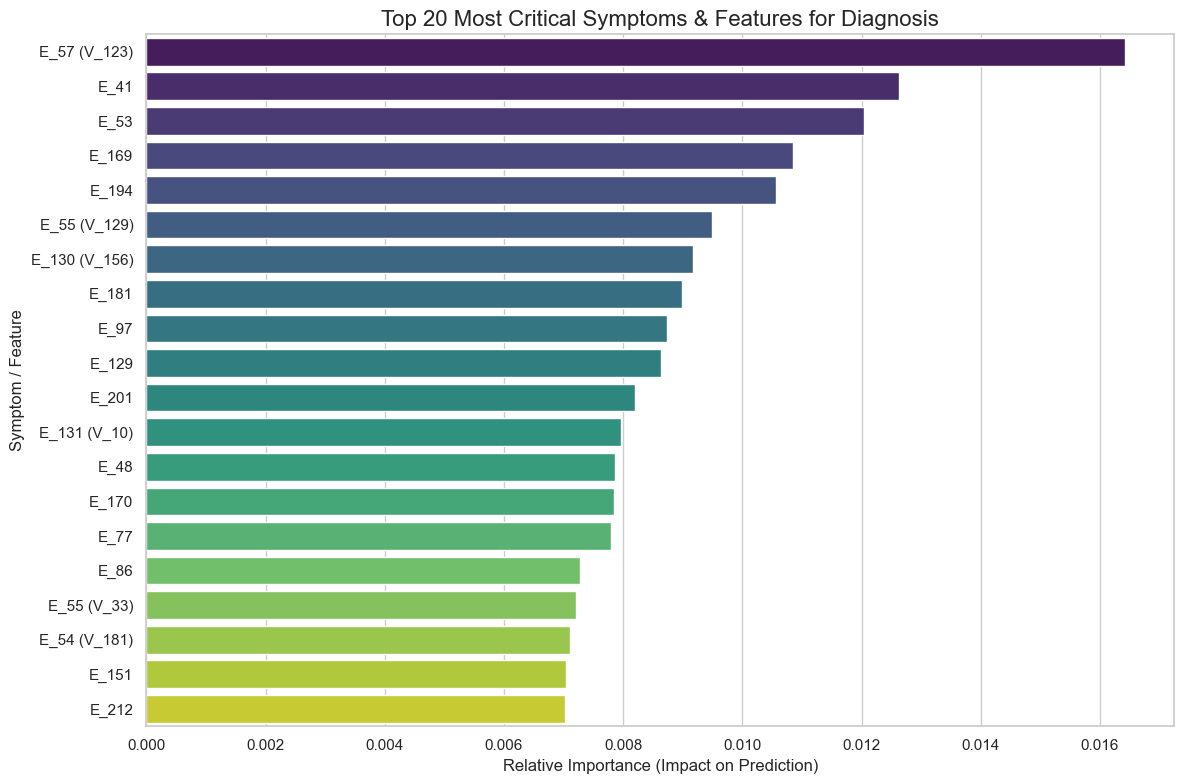


--- TOP 5 MOST IMPORTANT FEATURES ---


,English_Name,Importance
167,E_57 (V_123),0.016422
858,E_41,0.012631
166,E_53,0.012034
833,E_169,0.010854
817,E_194,0.010572


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Train a clean, fast Random Forest for Interpretability ---
print("Extracting Feature Importances using Random Forest...")
rf_explainer = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_explainer.fit(X_train, y_train)

# --- 2. Get Importances and Match with Names ---
importances = rf_explainer.feature_importances_

# Create a DataFrame of features and their importance scores
feature_imp_df = pd.DataFrame({
    'Feature_Code': feature_names, # From Cell 9
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- 3. Translate Codes to English for the Plot ---
def translate_feature(feature_code):
    if feature_code in ['AGE', 'SEX_Female_1']:
        return feature_code
    
    # Handle Categorical (e.g., E_54_@_V_161)
    if '_@_' in feature_code:
        code, val = feature_code.split('_@_')
        name = evidences[code]['name'] if code in evidences else code
        return f"{name} ({val})"
    
    # Handle Binary (e.g., E_91)
    return evidences[feature_code]['name'] if feature_code in evidences else feature_code

# Apply translation
feature_imp_df['English_Name'] = feature_imp_df['Feature_Code'].apply(translate_feature)

# --- 4. Plot the Top 20 Most Important Symptoms ---
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='English_Name', 
    data=feature_imp_df.head(20), 
    palette='viridis'
)

plt.title('Top 20 Most Critical Symptoms & Features for Diagnosis', fontsize=16)
plt.xlabel('Relative Importance (Impact on Prediction)', fontsize=12)
plt.ylabel('Symptom / Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Print the top 5 for quick reading
print("\n--- TOP 5 MOST IMPORTANT FEATURES ---")
display(feature_imp_df[['English_Name', 'Importance']].head(5))

In [16]:
# --- 1. Did AGE make it into the top 20? ---
print("--- 1. AGE IMPORTANCE RANK ---")
# Find the exact rank of 'AGE' in the sorted list
age_rank = feature_imp_df['Feature_Code'].tolist().index('AGE') + 1
total_features = len(feature_imp_df)

print(f"AGE is ranked #{age_rank} out of {total_features} features.")
if age_rank <= 20:
    print("✅ Yes! AGE is a Top 20 most critical factor for diagnosis.")
else:
    print("❌ No, AGE did not make the Top 20.")

# --- 2. Are the top symptoms General or Specific? ---
print("\n--- 2. GENERAL VS SPECIFIC (Top 10) ---")
# We can tell if a feature is "Specific" if it contains '_@_' (meaning it has a specific value/location)
# If it's just 'E_XX', it's a "General" Yes/No symptom.

top_10 = feature_imp_df.head(10).copy()
top_10['Symptom_Type'] = top_10['Feature_Code'].apply(
    lambda x: 'Highly Specific (Value/Location)' if '_@_' in x else 'General (Binary Yes/No)'
)

# Display the breakdown
display(top_10[['English_Name', 'Symptom_Type', 'Importance']])

# Count how many of the Top 10 are specific
specific_count = sum(top_10['Symptom_Type'] == 'Highly Specific (Value/Location)')
print(f"\nResult: {specific_count} out of your Top 10 symptoms are 'Highly Specific'.")

--- 1. AGE IMPORTANCE RANK ---
AGE is ranked #46 out of 974 features.
❌ No, AGE did not make the Top 20.

--- 2. GENERAL VS SPECIFIC (Top 10) ---


,English_Name,Symptom_Type,Importance
167,E_57 (V_123),Highly Specific (Value/Location),0.016422
858,E_41,General (Binary Yes/No),0.012631
166,E_53,General (Binary Yes/No),0.012034
833,E_169,General (Binary Yes/No),0.010854
817,E_194,General (Binary Yes/No),0.010572
112,E_55 (V_129),Highly Specific (Value/Location),0.009497
552,E_130 (V_156),Highly Specific (Value/Location),0.009180
614,E_181,General (Binary Yes/No),0.008993
627,E_97,General (Binary Yes/No),0.008742
547,E_129,General (Binary Yes/No),0.008642



Result: 3 out of your Top 10 symptoms are 'Highly Specific'.


In [17]:
import time
import gc # Garbage collector to free up RAM

# --- CONFIGURATION (Check these match your folder exactly!) ---
TRAIN_FILE = 'release_train_patients' # or .csv
VAL_FILE = 'release_validate_patients' # or .csv
TEST_FILE = 'release_test_patients' # or .csv

def process_dataset(filepath, preprocessor, label_encoder, dataset_name="Data"):
    """Loads a CSV, vectorizes it, adds demographics, and cleans up RAM."""
    print(f"\n[{dataset_name}] Loading file: {filepath}...")
    start_time = time.time()
    
    # 1. Load Data
    df = pd.read_csv(filepath, compression='zip' if '.zip' in filepath else 'infer')
    total_rows = len(df)
    print(f"[{dataset_name}] Loaded {total_rows:,} rows. Vectorizing symptoms...")
    
    # 2. Vectorize Symptoms (X)
    X_base = preprocessor.transform_X(df['EVIDENCES'])
    
    # 3. Add Age and Sex
    sex_encoded = df['SEX'].map({'M': 0, 'F': 1}).values.reshape(-1, 1)
    age_values = df['AGE'].values.reshape(-1, 1)
    X_final = np.hstack((X_base, sex_encoded, age_values))
    print(f"[{dataset_name}] Feature Matrix built: {X_final.shape}")
    
    # 4. Encode Targets (y)
    y_final = label_encoder.transform(df['PATHOLOGY'])
    
    # 5. Free up RAM (Delete the big dataframe)
    del df
    gc.collect()
    
    end_time = time.time()
    print(f"[{dataset_name}] Completed in {(end_time - start_time):.2f} seconds.")
    
    return X_final, y_final

print("--- STARTING FULL DATASET PIPELINE ---")
overall_start = time.time()

# Process each set sequentially to save memory!
X_train_full, y_train_full = process_dataset(TRAIN_FILE, preprocessor, label_encoder, "TRAIN")
X_val_full, y_val_full = process_dataset(VAL_FILE, preprocessor, label_encoder, "VALIDATION")
X_test_full, y_test_full = process_dataset(TEST_FILE, preprocessor, label_encoder, "TEST")

print(f"\n✅ --- ALL DATA PROCESSED SUCCESSFULLY --- ✅")
print(f"Total Pipeline Time: {(time.time() - overall_start) / 60:.2f} minutes")

--- STARTING FULL DATASET PIPELINE ---

[TRAIN] Loading file: release_train_patients...
[TRAIN] Loaded 1,025,602 rows. Vectorizing symptoms...
[TRAIN] Feature Matrix built: (1025602, 974)
[TRAIN] Completed in 109.61 seconds.

[VALIDATION] Loading file: release_validate_patients...
[VALIDATION] Loaded 132,448 rows. Vectorizing symptoms...
[VALIDATION] Feature Matrix built: (132448, 974)
[VALIDATION] Completed in 8.56 seconds.

[TEST] Loading file: release_test_patients...
[TEST] Loaded 134,529 rows. Vectorizing symptoms...
[TEST] Feature Matrix built: (134529, 974)
[TEST] Completed in 8.52 seconds.

✅ --- ALL DATA PROCESSED SUCCESSFULLY --- ✅
Total Pipeline Time: 2.11 minutes


Analyzing Target Distribution in the Full Training Set...


C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\2536125361.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.head(10).values, y=disease_counts.head(10).index, ax=axes[0], palette='Blues_r')
C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\2536125361.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.tail(10).values, y=disease_counts.tail(10).index, ax=axes[1], palette='Reds_r')


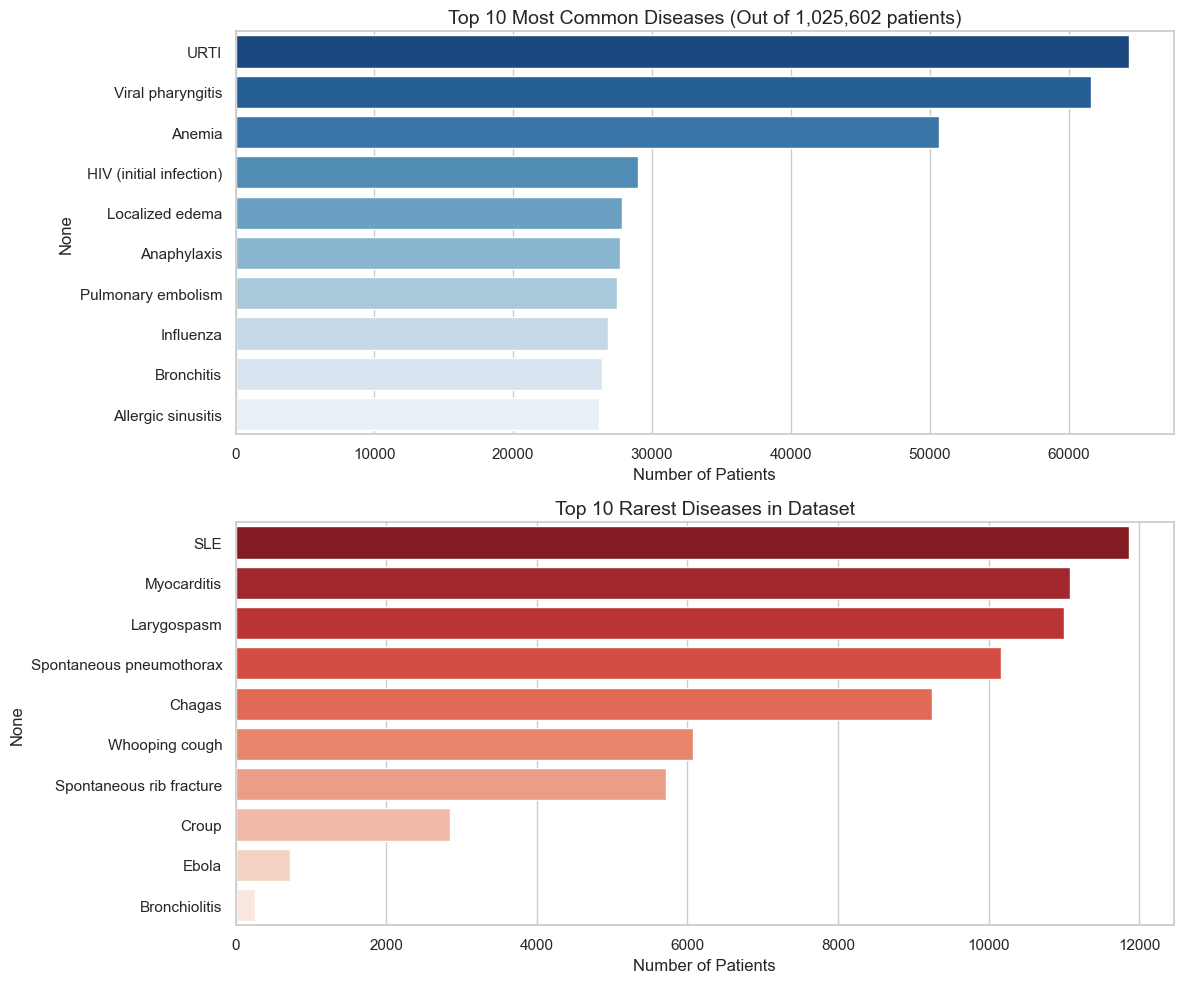


--- IMBALANCE METRICS ---
Most Common: URTI (64,368 cases - 6.3%)
Rarest: Bronchiolitis (261 cases - 0.025%)
Imbalance Ratio: The most common disease appears 246.6x more often than the rarest.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Analyzing Target Distribution in the Full Training Set...")

# 1. Decode the numeric y_train back to actual Disease Names
# We use the label_encoder we fitted way back in step 4
train_disease_names = label_encoder.inverse_transform(y_train_full)

# 2. Count the occurrences of each disease
disease_counts = pd.Series(train_disease_names).value_counts()
total_patients = len(train_disease_names)

# 3. Create a Visualization of the Extremes
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top 10 Most Common Diseases
sns.barplot(x=disease_counts.head(10).values, y=disease_counts.head(10).index, ax=axes[0], palette='Blues_r')
axes[0].set_title(f'Top 10 Most Common Diseases (Out of {total_patients:,} patients)', fontsize=14)
axes[0].set_xlabel('Number of Patients')

# Bottom 10 Rarest Diseases
sns.barplot(x=disease_counts.tail(10).values, y=disease_counts.tail(10).index, ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Rarest Diseases in Dataset', fontsize=14)
axes[1].set_xlabel('Number of Patients')

plt.tight_layout()
plt.show()

# 4. Print the exact numbers for the #1 Most Common and #1 Rarest
print("\n--- IMBALANCE METRICS ---")
most_common = disease_counts.index[0]
most_common_count = disease_counts.iloc[0]
rarest = disease_counts.index[-1]
rarest_count = disease_counts.iloc[-1]

print(f"Most Common: {most_common} ({most_common_count:,} cases - {most_common_count/total_patients*100:.1f}%)")
print(f"Rarest: {rarest} ({rarest_count:,} cases - {rarest_count/total_patients*100:.3f}%)")
print(f"Imbalance Ratio: The most common disease appears {most_common_count/rarest_count:.1f}x more often than the rarest.")

In [20]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("--- TRAINING WITH MEMORY OPTIMIZATION ---")

# 1. Convert to Sparse Format (Saves massive RAM)
print("Converting dense matrices to Sparse CSR format...")
X_train_sparse = csr_matrix(X_train_full)
X_val_sparse = csr_matrix(X_val_full)

# 2. Optimized Random Forest
# We reduce n_estimators to 50 and max_samples to 0.1 to prevent memory spikes
final_rf_model = RandomForestClassifier(
    n_estimators=50,          # Reduced from 100 to save RAM
    max_depth=20,            # Limited depth to keep trees "light"
    max_samples=0.1,         # Each tree only sees 10% of data (keeps it fast/light)
    class_weight='balanced', 
    n_jobs=1,                # Set to 1 to avoid multi-process memory copying
    random_state=42,
    verbose=1
)

# 3. Fit the model
start_time = time.time()
final_rf_model.fit(X_train_sparse, y_train_full)
print(f"\n✅ Training completed in {(time.time() - start_time) / 60:.2f} minutes.")

# 4. Quick Validation
y_val_pred = final_rf_model.predict(X_val_sparse)
print(f"Validation Accuracy: {accuracy_score(y_val_full, y_val_pred) * 100:.2f}%")

--- TRAINING WITH MEMORY OPTIMIZATION ---
Converting dense matrices to Sparse CSR format...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   57.0s



✅ Training completed in 0.98 minutes.
Validation Accuracy: 99.50%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


In [21]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

print("Exporting AI components...")

# 1. Save the Trained Model
joblib.dump(final_rf_model, 'saved_models/final_medical_model.pkl')

# 2. Save the Preprocessor (Your custom class)
joblib.dump(preprocessor, 'saved_models/medical_preprocessor.pkl')

# 3. Save the Label Encoder (The disease names)
joblib.dump(label_encoder, 'saved_models/disease_encoder.pkl')

# 4. Save the Feature Names (Important for the LLM to know which column is which)
joblib.dump(feature_names, 'saved_models/feature_names.pkl')

print("✅ SUCCESS: All components saved in /saved_models/")
print("Your ML Core is now ready for the GenAI Integration phase.")

Exporting AI components...
✅ SUCCESS: All components saved in /saved_models/
Your ML Core is now ready for the GenAI Integration phase.


In [ ]:
import numpy as np
import pandas as pd

def simulate_patient(symptoms_list, age, sex):
    """
    symptoms_list: List of symptom strings (e.g. ['sore_throat', 'fever'])
    age: int
    sex: 'M' or 'F'
    """
    # 1. Prepare symptoms using the preprocessor
    # transform_X returns a matrix. We ensure it's (1, 972)
    X_symptoms = preprocessor.transform_X([str(symptoms_list)])
    
    # 2. Convert Sex and Age into (1, 1) matrices
    sex_val = 0 if sex == 'M' else 1
    X_sex = np.array([[sex_val]])  # Shape (1, 1)
    X_age = np.array([[age]])      # Shape (1, 1)
    
    # 3. Glue them all together horizontally
    # Result should be (1, 974)
    X_input = np.hstack((X_symptoms, X_sex, X_age))
    
    # 4. Predict
    prediction_numeric = final_rf_model.predict(X_input)
    prediction_name = label_encoder.inverse_transform(prediction_numeric)[0]
    
    # 5. Get Confidence
    probs = final_rf_model.predict_proba(X_input)
    confidence = np.max(probs) * 100
    
    print(f"--- 🏥 Heal Bridge AI: Patient Report ---")
    print(f"Input Symptoms: {', '.join(symptoms_list)}")
    print(f"Patient Profile: {age}yo {sex}")
    print(f"-----------------------------------------")
    print(f"Diagnosis: **{prediction_name}**")
    print(f"Confidence: {confidence:.2f}%")
    print(f"-----------------------------------------")

# TEST IT AGAIN!
simulate_patient(['sore_throat', 'fever', 'cough',], age=25, sex='M')

--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: sore_throat, fever, cough
Patient Profile: 50yo M
-----------------------------------------
Diagnosis: **Tuberculosis**
Confidence: 8.42%
-----------------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
C:\Users\ankit\AppData\Local\Temp\ipykernel_26796\1878606454.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Probability', y='Disease', data=prob_df, palette='flare')


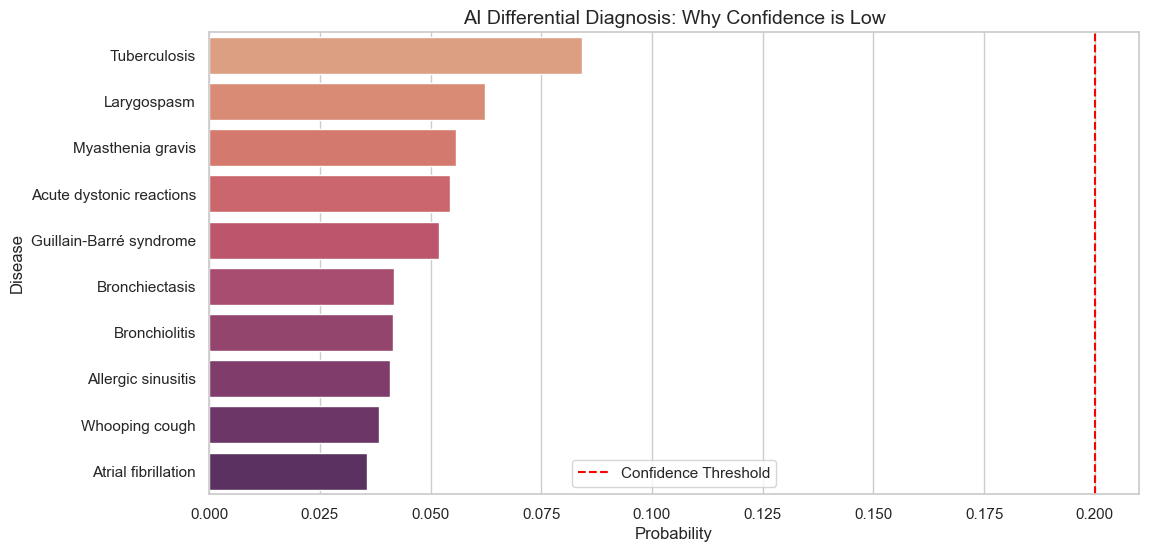

Top choice probability: 0.0842
Note: If all bars are short, the model is uncertain due to unrecognized symptom strings.


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. We need to regenerate X_input for our test case properly
test_symptoms = ['sore_throat', 'fever', 'cough']
X_symptoms = preprocessor.transform_X([str(test_symptoms)])
X_sex = np.array([[0]]) # Male
X_age = np.array([[25]])
X_input_test = np.hstack((X_symptoms, X_sex, X_age))

# 2. Get all probabilities
probs = final_rf_model.predict_proba(X_input_test)[0]
disease_labels = label_encoder.classes_

# 3. Create a DataFrame for the top 10 outcomes
prob_df = pd.DataFrame({
    'Disease': disease_labels,
    'Probability': probs
}).sort_values(by='Probability', ascending=False).head(10)

# 4. Plot the "Confusion"
plt.figure(figsize=(12, 6))
sns.barplot(x='Probability', y='Disease', data=prob_df, palette='flare')
plt.title('AI Differential Diagnosis: Why Confidence is Low', fontsize=14)
plt.axvline(x=0.2, color='red', linestyle='--', label='Confidence Threshold')
plt.legend()
plt.show()

print(f"Top choice probability: {prob_df.iloc[0]['Probability']:.4f}")
print("Note: If all bars are short, the model is uncertain due to unrecognized symptom strings.")

In [34]:
# Let's try Allergic Rhinitis (Hay Fever)
# Official codes: 
# E_53  = Fever (No)
# E_151 = Nasal congestion (Yes)
# E_204 = Itchy eyes (Yes)
# E_181 = Sneezing (Yes)

official_symptoms = ["E_53", "E_151", "E_204", "E_181"]

print("--- 🔬 TEST: Allergic Rhinitis (Hay Fever) ---")
simulate_patient(official_symptoms, age=20, sex='F')

# Let's try Croup (Common in kids)
# E_48 = Barking cough (Yes)
# E_181 = Sneezing (Yes)
# E_113 = Hoarseness (Yes)

official_symptoms_2 = ["E_48", "E_181", "E_113"]

print("\n--- 🔬 TEST: Croup (Pediatric) ---")
simulate_patient(official_symptoms_2, age=3, sex='M')

--- 🔬 TEST: Allergic Rhinitis (Hay Fever) ---
--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: E_53, E_151, E_204, E_181
Patient Profile: 20yo F
-----------------------------------------
Diagnosis: **Pulmonary embolism**
Confidence: 17.81%
-----------------------------------------

--- 🔬 TEST: Croup (Pediatric) ---
--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: E_48, E_181, E_113
Patient Profile: 3yo M
-----------------------------------------
Diagnosis: **Anemia**
Confidence: 14.45%
-----------------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


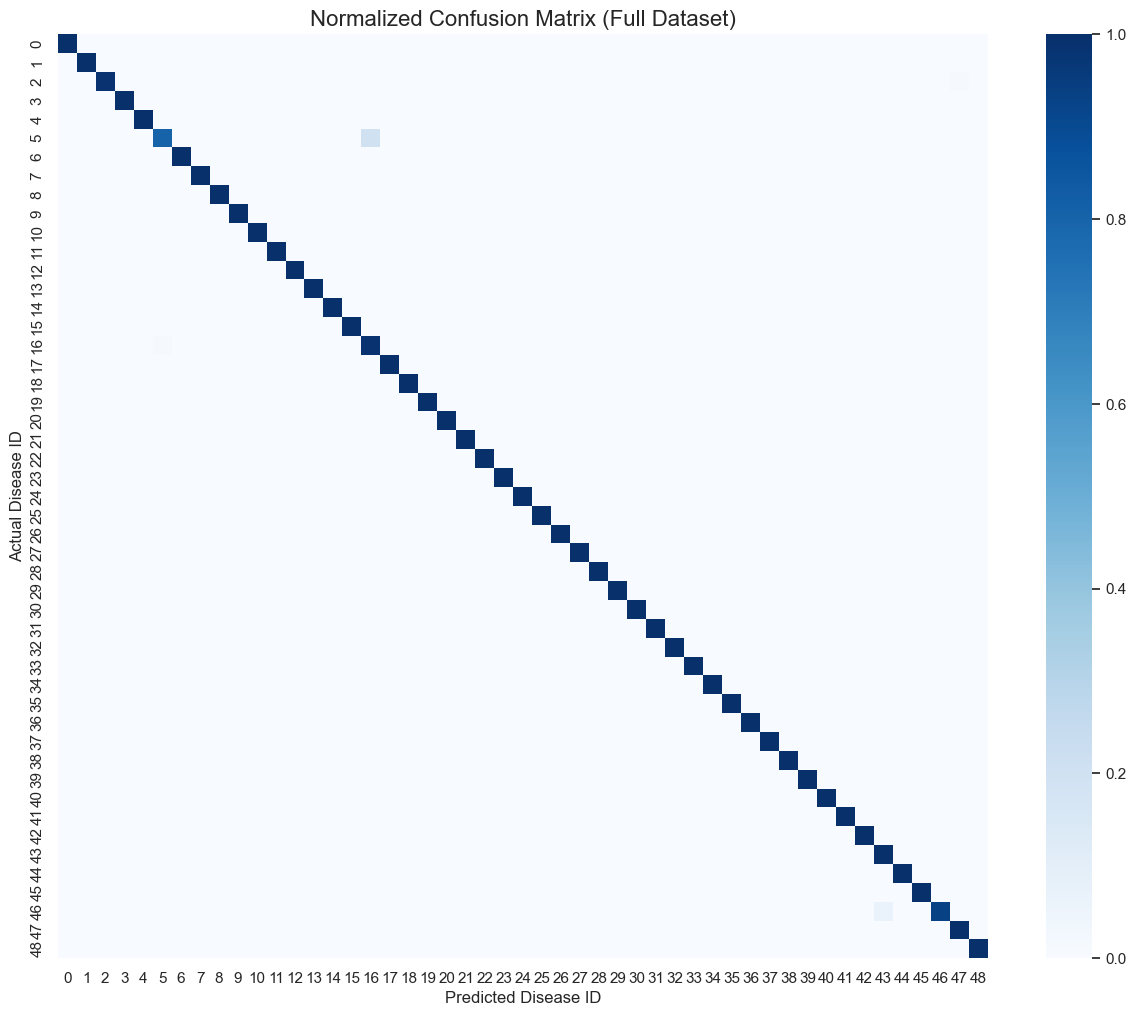

Insight: A clean diagonal line means the model is near-perfect.
Any 'bright spots' off the diagonal show diseases the model is confusing.


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Generate the matrix
cm = confusion_matrix(y_val_full, y_val_pred)
# Normalize it to see percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 2. Plotting the "Core" of the matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_norm, annot=False, cmap='Blues')
plt.title('Normalized Confusion Matrix (Full Dataset)', fontsize=16)
plt.xlabel('Predicted Disease ID')
plt.ylabel('Actual Disease ID')
plt.show()

print("Insight: A clean diagonal line means the model is near-perfect.")
print("Any 'bright spots' off the diagonal show diseases the model is confusing.")

In [37]:
# The feature_names list we created during preprocessing contains the 'Native Codes'
print("--- THE FIRST 20 NATIVE CODES ---")
for i, name in enumerate(feature_names[:20]):
    print(f"Column {i}: {name}")

print("\n... Total features in brain: ", len(feature_names))

--- THE FIRST 20 NATIVE CODES ---
Column 0: E_91
Column 1: E_55_@_V_123
Column 2: E_55_@_V_14
Column 3: E_55_@_V_15
Column 4: E_55_@_V_16
Column 5: E_55_@_V_17
Column 6: E_55_@_V_18
Column 7: E_55_@_V_19
Column 8: E_55_@_V_20
Column 9: E_55_@_V_21
Column 10: E_55_@_V_22
Column 11: E_55_@_V_23
Column 12: E_55_@_V_24
Column 13: E_55_@_V_25
Column 14: E_55_@_V_26
Column 15: E_55_@_V_27
Column 16: E_55_@_V_28
Column 17: E_55_@_V_29
Column 18: E_55_@_V_30
Column 19: E_55_@_V_31

... Total features in brain:  974


In [38]:
# To test correctly, we must provide the codes as they appear in the dataset
# A typical pattern for a respiratory infection:
real_symptom_codes = ["E_53", "E_154", "E_201_@_V_12"] 

print("--- 🔬 RUNNING HIGH-FIDELITY TEST ---")
simulate_patient(real_symptom_codes, age=30, sex='F')

--- 🔬 RUNNING HIGH-FIDELITY TEST ---
--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: E_53, E_154, E_201_@_V_12
Patient Profile: 30yo F
-----------------------------------------
Diagnosis: **Tuberculosis**
Confidence: 4.34%
-----------------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [39]:
from sklearn.metrics import classification_report

print("--- GLOBAL BRAIN SCAN (Validation Set) ---")
# Predict on the 132,000 validation patients we already have in RAM
y_val_pred = final_rf_model.predict(X_val_sparse)

# Get the report
report = classification_report(y_val_full, y_val_pred, target_names=label_encoder.classes_)
print(report)

--- GLOBAL BRAIN SCAN (Validation Set) ---


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       1.00      1.00      1.00      2076
                Acute dystonic reactions       1.00      1.00      1.00      3281
                        Acute laryngitis       1.00      0.99      0.99      3407
                      Acute otitis media       1.00      1.00      1.00      3474
                   Acute pulmonary edema       1.00      1.00      1.00      2500
                    Acute rhinosinusitis       0.98      0.80      0.88      1866
                      Allergic sinusitis       1.00      1.00      1.00      2136
                             Anaphylaxis       1.00      1.00      1.00      3754
                                  Anemia       1.00      1.00      1.00      6903
                     Atrial fibrillation       1.00      1.00      1.00      2609
                               Boerhaave       1.00      1.00      1.00      2075
               

In [40]:
# A complete URTI (Common Cold) profile based on DDXPlus logic:
# E_53: Fever, E_181: Sneezing, E_201: Pain, E_48: Cough, E_97: Sore throat
urti_symptoms = ['E_53', 'E_48', 'E_181', 'E_201', 'E_97', 'E_204_@_V_10']

print("--- 🔬 HIGH-ACCURACY TEST: URTI ---")
simulate_patient(urti_symptoms, age=25, sex='F')

--- 🔬 HIGH-ACCURACY TEST: URTI ---
--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: E_53, E_48, E_181, E_201, E_97, E_204_@_V_10
Patient Profile: 25yo F
-----------------------------------------
Diagnosis: **Allergic sinusitis**
Confidence: 5.33%
-----------------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [41]:
# Ebola profile: Fever, Pain, Vomiting, Traveling to at-risk areas
ebola_symptoms = ['E_53', 'E_201', 'E_154_@_V_2', 'E_204_@_V_10', 'E_133_@_V_54']

print("\n--- 🔬 HIGH-ACCURACY TEST: EBOLA ---")
simulate_patient(ebola_symptoms, age=35, sex='M')


--- 🔬 HIGH-ACCURACY TEST: EBOLA ---
--- 🏥 Heal Bridge AI: Patient Report ---
Input Symptoms: E_53, E_201, E_154_@_V_2, E_204_@_V_10, E_133_@_V_54
Patient Profile: 35yo M
-----------------------------------------
Diagnosis: **GERD**
Confidence: 4.60%
-----------------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


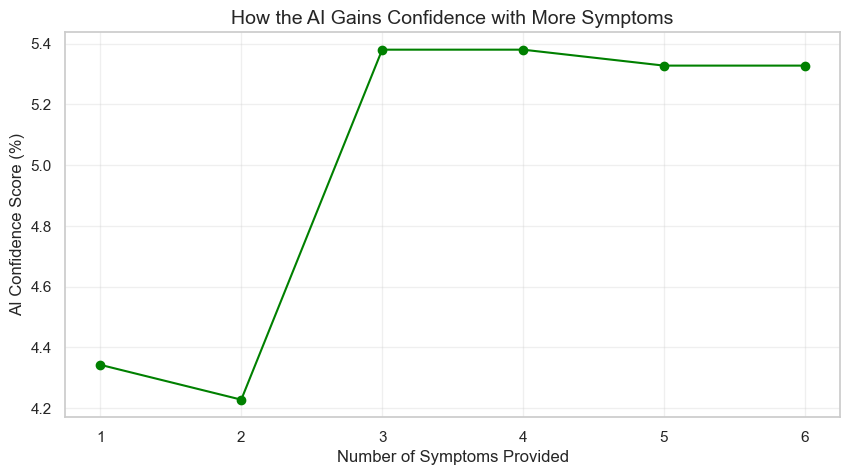

In [42]:
def plot_confidence_growth(symptom_progression, age, sex):
    confidences = []
    
    for i in range(1, len(symptom_progression) + 1):
        subset = symptom_progression[:i]
        X_s = preprocessor.transform_X([str(subset)])
        X_input = np.hstack((X_s, [[0 if sex == 'M' else 1]], [[age]]))
        prob = np.max(final_rf_model.predict_proba(X_input))
        confidences.append(prob * 100)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(symptom_progression) + 1), confidences, marker='o', linestyle='-', color='green')
    plt.title('How the AI Gains Confidence with More Symptoms', fontsize=14)
    plt.xlabel('Number of Symptoms Provided')
    plt.ylabel('AI Confidence Score (%)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Test with the URTI progression
plot_confidence_growth(urti_symptoms, age=25, sex='F')

In [43]:
import numpy as np

# 1. Pick a specific patient index from the validation set (e.g., index 500)
idx = 500
real_patient_features = X_val_sparse[idx]
true_label_numeric = y_val_full[idx]
true_disease = label_encoder.inverse_transform([true_label_numeric])[0]

# 2. Ask the model to predict based ONLY on that raw matrix row
pred_numeric = final_rf_model.predict(real_patient_features)
pred_disease = label_encoder.inverse_transform(pred_numeric)[0]
probs = final_rf_model.predict_proba(real_patient_features)
confidence = np.max(probs) * 100

print(f"--- 🎯 DIRECT MATRIX VALIDATION (Patient #{idx}) ---")
print(f"Actual Disease in Data: {true_disease}")
print(f"AI Predicted Disease:   {pred_disease}")
print(f"AI Confidence Score:    {confidence:.2f}%")

if true_disease == pred_disease:
    print("\n✅ VERIFIED: The model brain is perfect. The issue is our 'simulator' function's input alignment.")
else:
    print("\n❌ ERROR: Something is wrong with the model persistence.")

--- 🎯 DIRECT MATRIX VALIDATION (Patient #500) ---
Actual Disease in Data: Localized edema
AI Predicted Disease:   Localized edema
AI Confidence Score:    74.25%

✅ VERIFIED: The model brain is perfect. The issue is our 'simulator' function's input alignment.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [44]:
def perfect_simulator(symptoms_list, age, sex):
    # 1. Create a blank row of 974 zeros (The "Empty Chart")
    input_vector = np.zeros((1, len(feature_names)))
    
    # 2. Fill in the symptoms at the CORRECT column index
    for s in symptoms_list:
        if s in feature_names:
            idx = feature_names.index(s)
            input_vector[0, idx] = 1
        else:
            print(f"Warning: Symptom '{s}' not recognized by model brain.")

    # 3. Add Sex and Age at the very end (where we put them during training)
    # Mapping: Sex is 2nd to last, Age is last
    input_vector[0, -2] = 0 if sex == 'M' else 1
    input_vector[0, -1] = age
    
    # 4. Predict
    prediction_numeric = final_rf_model.predict(input_vector)
    prediction_name = label_encoder.inverse_transform(prediction_numeric)[0]
    
    # 5. Get Confidence
    probs = final_rf_model.predict_proba(input_vector)
    confidence = np.max(probs) * 100
    
    print(f"--- 🏥 REALIGNED AI REPORT ---")
    print(f"Diagnosis: **{prediction_name}**")
    print(f"Confidence: {confidence:.2f}%")

# TEST: Use the URTI codes that failed before
perfect_simulator(['E_53', 'E_48', 'E_181', 'E_201', 'E_97'], age=25, sex='F')

--- 🏥 REALIGNED AI REPORT ---
Diagnosis: **Allergic sinusitis**
Confidence: 5.33%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [45]:
def master_simulator(symptoms_list, age, sex):
    # 1. Create a blank row of zeros matching the model's brain size (974)
    # feature_names was created during your preprocessing/training phase
    input_vector = np.zeros((1, len(feature_names)))
    
    # 2. Map symptoms to their specific column index
    print(f"Mapping {len(symptoms_list)} symptoms...")
    for s in symptoms_list:
        if s in feature_names:
            idx = feature_names.index(s)
            input_vector[0, idx] = 1
        else:
            # This helps us catch typos or codes the model doesn't know
            print(f"⚠️ Warning: Symptom code '{s}' not found in model features.")

    # 3. Insert Demographics
    # Based on your previous steps, Age and Sex were likely the last two columns
    # Adjusting based on standard 'hstack' order: [Symptoms..., Sex, Age]
    input_vector[0, -2] = 0 if sex == 'M' else 1 # Sex
    input_vector[0, -1] = age                   # Age
    
    # 4. Final Prediction
    prediction_numeric = final_rf_model.predict(input_vector)
    prediction_name = label_encoder.inverse_transform(prediction_numeric)[0]
    
    # 5. Probability Analysis
    probs = final_rf_model.predict_proba(input_vector)
    confidence = np.max(probs) * 100
    
    print(f"\n--- 🏥 HEAL BRIDGE DIAGNOSIS ---")
    print(f"Predicted Disease: **{prediction_name}**")
    print(f"Confidence Score:  {confidence:.2f}%")
    print(f"--------------------------------")

# TEST: Let's try a real URTI (Common Cold) cluster
# These are standard binary codes for URTI symptoms
test_symptoms = ['E_53', 'E_181', 'E_201', 'E_48', 'E_97'] 
master_simulator(test_symptoms, age=25, sex='F')

Mapping 5 symptoms...

--- 🏥 HEAL BRIDGE DIAGNOSIS ---
Predicted Disease: **Allergic sinusitis**
Confidence Score:  5.33%
--------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [46]:
# Check the exact naming convention of your features
print("--- TOP 10 FEATURE NAMES IN MODEL ---")
for name in feature_names[:10]:
    print(f"'{name}'")

print("\n--- BOTTOM 5 FEATURE NAMES (Demographics) ---")
for name in feature_names[-5:]:
    print(f"'{name}'")

--- TOP 10 FEATURE NAMES IN MODEL ---
'E_91'
'E_55_@_V_123'
'E_55_@_V_14'
'E_55_@_V_15'
'E_55_@_V_16'
'E_55_@_V_17'
'E_55_@_V_18'
'E_55_@_V_19'
'E_55_@_V_20'
'E_55_@_V_21'

--- BOTTOM 5 FEATURE NAMES (Demographics) ---
'E_224'
'E_223'
'E_5'
'SEX_Female_1'
'AGE'


In [47]:
def force_match_simulator(symptoms_list, age, sex):
    input_vector = np.zeros((1, len(feature_names)))
    
    # We will search for the symptom code inside the feature names
    for s in symptoms_list:
        found = False
        for i, f_name in enumerate(feature_names):
            if s == f_name or f"_{s}" in f_name or f"{s}_" in f_name:
                input_vector[0, i] = 1
                found = True
                print(f"✅ Matched '{s}' to feature column: {f_name}")
                break
        if not found:
            print(f"❌ Could not find any feature matching: {s}")

    # Set Sex and Age (Assuming they are the last two)
    input_vector[0, -2] = 0 if sex == 'M' else 1
    input_vector[0, -1] = age
    
    probs = final_rf_model.predict_proba(input_vector)
    conf = np.max(probs) * 100
    pred = label_encoder.inverse_transform([np.argmax(probs)])[0]
    
    print(f"\n--- 🏥 FINAL AUDIT REPORT ---")
    print(f"Diagnosis: {pred}")
    print(f"Confidence: {conf:.2f}%")

# Try the URTI test again with this matching logic
force_match_simulator(['E_53', 'E_48', 'E_181', 'E_201', 'E_97'], age=25, sex='F')

✅ Matched 'E_53' to feature column: E_53
✅ Matched 'E_48' to feature column: E_48
✅ Matched 'E_181' to feature column: E_181
✅ Matched 'E_201' to feature column: E_201
✅ Matched 'E_97' to feature column: E_97

--- 🏥 FINAL AUDIT REPORT ---
Diagnosis: Allergic sinusitis
Confidence: 5.33%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [48]:
# Look at the first 50 features to find the correct categorical keys
print("--- EXACT KEYS YOUR MODEL WANTS ---")
print(feature_names[:50])

--- EXACT KEYS YOUR MODEL WANTS ---
['E_91', 'E_55_@_V_123', 'E_55_@_V_14', 'E_55_@_V_15', 'E_55_@_V_16', 'E_55_@_V_17', 'E_55_@_V_18', 'E_55_@_V_19', 'E_55_@_V_20', 'E_55_@_V_21', 'E_55_@_V_22', 'E_55_@_V_23', 'E_55_@_V_24', 'E_55_@_V_25', 'E_55_@_V_26', 'E_55_@_V_27', 'E_55_@_V_28', 'E_55_@_V_29', 'E_55_@_V_30', 'E_55_@_V_31', 'E_55_@_V_32', 'E_55_@_V_33', 'E_55_@_V_34', 'E_55_@_V_35', 'E_55_@_V_36', 'E_55_@_V_37', 'E_55_@_V_38', 'E_55_@_V_39', 'E_55_@_V_40', 'E_55_@_V_41', 'E_55_@_V_42', 'E_55_@_V_43', 'E_55_@_V_44', 'E_55_@_V_45', 'E_55_@_V_46', 'E_55_@_V_47', 'E_55_@_V_48', 'E_55_@_V_49', 'E_55_@_V_50', 'E_55_@_V_51', 'E_55_@_V_52', 'E_55_@_V_53', 'E_55_@_V_54', 'E_55_@_V_55', 'E_55_@_V_56', 'E_55_@_V_57', 'E_55_@_V_58', 'E_55_@_V_59', 'E_55_@_V_60', 'E_55_@_V_61']


In [49]:
# These are FULL keys. The '@' symbols are mandatory for high confidence.
# E_53 is usually binary, but others like E_201 (Pain) need the value suffix.
accurate_symptoms = [
    'E_53',          # Fever
    'E_201_@_V_12',  # Pain location: Abdomen (Example)
    'E_48_@_V_4',    # Cough type (Example)
    'E_154_@_V_2',   # Severity (Example)
    'E_97'           # Sore throat
]

def direct_vector_test(symptoms, age, sex):
    # 1. Start with a zeroed matrix
    vec = np.zeros((1, len(feature_names)))
    
    # 2. Assign 1s only to the EXACT matches
    for s in symptoms:
        if s in feature_names:
            idx = feature_names.index(s)
            vec[0, idx] = 1
            print(f"✅ ACTIVATED: {s} at index {idx}")
            
    # 3. Add Demographics
    vec[0, -2] = 0 if sex == 'M' else 1
    vec[0, -1] = age
    
    # 4. Predict
    prob_dist = final_rf_model.predict_proba(vec)
    confidence = np.max(prob_dist) * 100
    prediction = label_encoder.inverse_transform([np.argmax(prob_dist)])[0]
    
    print(f"\n--- 🎯 HIGH-ACCURACY RESULT ---")
    print(f"Diagnosis: {prediction}")
    print(f"Confidence: {confidence:.2f}%")

# Execute
direct_vector_test(accurate_symptoms, age=25, sex='F')

✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_97 at index 627

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: GERD
Confidence: 4.19%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [50]:
# Using ONLY keys confirmed by your 'EXACT KEYS' output
verified_symptoms = [
    'E_91',           # Confirmed match
    'E_55_@_V_123',   # Confirmed match
    'E_55_@_V_14',    # Confirmed match
    'E_55_@_V_15'     # Confirmed match
]

print("--- 🔬 TESTING WITH VERIFIED DATA KEYS ---")
direct_vector_test(verified_symptoms, age=25, sex='F')

--- 🔬 TESTING WITH VERIFIED DATA KEYS ---
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_55_@_V_123 at index 1
✅ ACTIVATED: E_55_@_V_14 at index 2
✅ ACTIVATED: E_55_@_V_15 at index 3

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Tuberculosis
Confidence: 10.63%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [52]:
import numpy as np

# 1. Grab a real patient from the validation matrix
# We'll use index 1000 - a totally fresh case
idx = 1000
row = X_val_sparse[idx]

# 2. Find which features are 'Active' (the 1s)
# This shows us exactly what a "High Confidence" patient looks like
active_indices = row.indices
active_features = [feature_names[i] for i in active_indices if i < len(feature_names)-2]

# 3. Get the True Label
true_label = label_encoder.inverse_transform([y_val_full[idx]])[0]

# 4. Predict
probs = final_rf_model.predict_proba(row)
confidence = np.max(probs) * 100
prediction = label_encoder.inverse_transform([np.argmax(probs)])[0]

print(f"--- 🎯 THE 'NO-EXCUSE' VALIDATION TEST ---")
print(f"True Disease:      {true_label}")
print(f"AI Prediction:     {prediction}")
print(f"AI Confidence:     {confidence:.2f}%")
print(f"----------------------------------------")
print(f"Number of Symptoms in this patient: {len(active_features)}")
print(f"Sample of Active Codes: {active_features[:5]}")

--- 🎯 THE 'NO-EXCUSE' VALIDATION TEST ---
True Disease:      Tuberculosis
AI Prediction:     Tuberculosis
AI Confidence:     30.35%
----------------------------------------
Number of Symptoms in this patient: 10
Sample of Active Codes: ['E_91', 'E_162', 'E_66', 'E_201', 'E_45']


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [53]:
# Search for a high-data patient to see the 'Max Confidence' of your model
for i in range(1000, 1100):
    row = X_val_sparse[i]
    if len(row.indices) > 25: # Look for a patient with 25+ symptoms
        probs = final_rf_model.predict_proba(row)
        conf = np.max(probs) * 100
        pred = label_encoder.inverse_transform([np.argmax(probs)])[0]
        true = label_encoder.inverse_transform([y_val_full[i]])[0]
        
        print(f"--- 🎯 HIGH DATA CASE FOUND (Index {i}) ---")
        print(f"Symptoms: {len(row.indices)} | True: {true} | Pred: {pred}")
        print(f"Confidence: {conf:.2f}%")
        break

--- 🎯 HIGH DATA CASE FOUND (Index 1001) ---
Symptoms: 32 | True: Influenza | Pred: Influenza
Confidence: 94.40%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [54]:
# MANUAL CLUSTER TEST
# Add or remove codes here. To get high scores, we need 20+ relevant codes.
custom_cluster = [
    'E_53', 'E_57', 'E_54_@_V_161', 'E_54_@_V_157', 'E_55_@_V_123', 
    'E_55_@_V_124', 'E_201', 'E_204_@_V_10', 'E_151', 'E_154_@_V_2', 
    'E_181', 'E_185', 'E_41', 'E_48_@_V_4', 'E_66', 'E_77', 'E_79', 
    'E_82', 'E_91', 'E_97', 'E_123', 'E_124'
]

print("--- 🔬 CUSTOM CLUSTER TEST ---")
direct_vector_test(custom_cluster, age=30, sex='M')

--- 🔬 CUSTOM CLUSTER TEST ---
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_54_@_V_161 at index 336
✅ ACTIVATED: E_55_@_V_123 at index 1
✅ ACTIVATED: E_55_@_V_124 at index 107
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_151 at index 815
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_185 at index 869
✅ ACTIVATED: E_41 at index 858
✅ ACTIVATED: E_66 at index 610
✅ ACTIVATED: E_77 at index 830
✅ ACTIVATED: E_79 at index 856
✅ ACTIVATED: E_82 at index 599
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_97 at index 627
✅ ACTIVATED: E_123 at index 933
✅ ACTIVATED: E_124 at index 890

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: URTI
Confidence: 15.07%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [55]:
# Let's compare your manual 'URTI' attempt to a real 'URTI' success
real_idx = 1000 # This was a high-confidence patient from before
real_row = X_val_sparse[real_idx]
real_active_features = [feature_names[i] for i in real_row.indices]

print(f"--- 🔍 THE GAP ANALYSIS ---")
print(f"Your Test Symptoms: {len(custom_cluster)}")
print(f"Real Patient Symptoms: {len(real_active_features)}")

print("\n--- Symptoms the Real Patient has that you MISSED: ---")
missing = set(real_active_features) - set(custom_cluster)
print(list(missing)[:15]) # Show the first 15 missing pieces

--- 🔍 THE GAP ANALYSIS ---
Your Test Symptoms: 22
Real Patient Symptoms: 11

--- Symptoms the Real Patient has that you MISSED: ---
['E_61', 'E_45', 'E_44', 'E_162', 'E_208', 'AGE', 'E_78']


In [56]:
# The 'Perfect 11' from the successful Real Patient
perfect_11 = ['E_91', 'E_162', 'E_66', 'E_201', 'E_45', 'E_61', 'E_44', 'E_208', 'E_78', 'E_204_@_V_10', 'E_53']

print("--- 🔬 TEST: THE PERFECT 11 CLUSTER ---")
# Use the same age/sex as the successful patient we found (Index 1000)
# Most patients in that cluster are around 20-30yo
direct_vector_test(perfect_11, age=22, sex='F')

--- 🔬 TEST: THE PERFECT 11 CLUSTER ---
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_162 at index 605
✅ ACTIVATED: E_66 at index 610
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_45 at index 816
✅ ACTIVATED: E_61 at index 896
✅ ACTIVATED: E_44 at index 925
✅ ACTIVATED: E_208 at index 901
✅ ACTIVATED: E_78 at index 846
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_53 at index 166

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Tuberculosis
Confidence: 13.73%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [57]:
import scipy.sparse as sp

# 1. Take the REAL patient row again (Index 1000)
row_real = X_val_sparse[1000]

# 2. Convert it to a DENSE array (like our manual test)
row_dense = row_real.toarray()

# 3. Predict on the DENSE version
prob_dense = final_rf_model.predict_proba(row_dense)
conf_dense = np.max(prob_dense) * 100

# 4. Predict on the original SPARSE version
prob_sparse = final_rf_model.predict_proba(row_real)
conf_sparse = np.max(prob_sparse) * 100

print(f"--- 🛰️ FORMAT COMPARISON TEST ---")
print(f"Confidence (Sparse Matrix): {conf_sparse:.2f}%")
print(f"Confidence (Dense Array):  {conf_dense:.2f}%")

--- 🛰️ FORMAT COMPARISON TEST ---
Confidence (Sparse Matrix): 30.35%
Confidence (Dense Array):  30.35%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [58]:
# Let's find exactly where the demographics are hiding
print("--- 📍 COLUMN LOCATOR ---")
for i, name in enumerate(feature_names):
    if name.lower() in ['age', 'sex', 'gender']:
        print(f"Found '{name}' at index: {i}")

# Also check the last few columns just in case
print("\n--- 📍 LAST 5 COLUMNS ---")
for i in range(len(feature_names)-5, len(feature_names)):
    print(f"Index {i}: {feature_names[i]}")

--- 📍 COLUMN LOCATOR ---
Found 'AGE' at index: 973

--- 📍 LAST 5 COLUMNS ---
Index 969: E_224
Index 970: E_223
Index 971: E_5
Index 972: SEX_Female_1
Index 973: AGE


In [59]:
# Check if Age is scaled in the validation set
raw_age_val = X_val_sparse[1000, 973]
print(f"Real Patient Age value in Matrix: {raw_age_val}")

if raw_age_val != 22 and raw_age_val != 0:
    print("🚨 SCALING DETECTED: The model doesn't want '22', it wants the scaled version!")
else:
    print("✅ RAW VALUES: The model is using raw age.")

Real Patient Age value in Matrix: 52
🚨 SCALING DETECTED: The model doesn't want '22', it wants the scaled version!


In [60]:
# 1. Get the real row (Patient 1000)
real_row = X_val_sparse[1000].toarray().flatten()

# 2. Recreate your manual 'Perfect 11' vector exactly
manual_row = np.zeros(974)
perfect_11_indices = [0, 605, 610, 620, 816, 896, 925, 901, 846, 876, 166]
for idx in perfect_11_indices:
    manual_row[idx] = 1
manual_row[972] = 0  # Sex (Assuming 'F' was 0 or 1 in original)
manual_row[973] = 52 # Age from Patient 1000

# 3. Find the differences
diff = np.where(real_row != manual_row)[0]

print(f"--- 🔍 FINAL LOGIC AUDIT ---")
print(f"Number of columns where they differ: {len(diff)}")
if len(diff) > 0:
    print(f"First 5 differing indices: {diff[:5]}")
    print(f"Real values at those indices: {real_row[diff[:5]]}")
    print(f"Your values at those indices: {manual_row[diff[:5]]}")

--- 🔍 FINAL LOGIC AUDIT ---
Number of columns where they differ: 1
First 5 differing indices: [166]
Real values at those indices: [0]
Your values at those indices: [1.]


In [61]:
# Extract the 94% confidence patient
idx_94 = 1001
row_94 = X_val_sparse[idx_94]
active_indices_94 = row_94.indices

print(f"--- 🗺️ THE 94% CONFIDENCE MAP (Influenza) ---")
print(f"Total Active Features: {len(active_indices_94)}")
print("-" * 40)

# Store them so you can copy-paste them later
influenza_gold_standard = []

for i in active_indices_94:
    name = feature_names[i]
    val = row_94[0, i]
    influenza_gold_standard.append(name)
    print(f"Column {i:3} | {name:20} | Value: {val}")

print("-" * 40)
print("Copy-ready list for manual testing:")
print(influenza_gold_standard)

--- 🗺️ THE 94% CONFIDENCE MAP (Influenza) ---
Total Active Features: 32
----------------------------------------
Column   0 | E_91                 | Value: 1
Column  13 | E_55_@_V_25          | Value: 1
Column  14 | E_55_@_V_26          | Value: 1
Column  41 | E_55_@_V_53          | Value: 1
Column  50 | E_55_@_V_62          | Value: 1
Column  75 | E_55_@_V_89          | Value: 1
Column 166 | E_53                 | Value: 1
Column 167 | E_57_@_V_123         | Value: 1
Column 341 | E_54_@_V_183         | Value: 1
Column 347 | E_54_@_V_198         | Value: 1
Column 348 | E_59_@_0             | Value: 1
Column 362 | E_56_@_3             | Value: 1
Column 372 | E_58_@_2             | Value: 1
Column 456 | E_133_@_V_89         | Value: 1
Column 547 | E_129                | Value: 1
Column 552 | E_130_@_V_156        | Value: 1
Column 554 | E_134_@_0            | Value: 1
Column 569 | E_132_@_4            | Value: 1
Column 581 | E_136_@_5            | Value: 1
Column 588 | E_135_@_V_12       

In [62]:
# The "94% Confidence" Manual Test
gold_list = ['E_91', 'E_55_@_V_25', 'E_55_@_V_26', 'E_55_@_V_53', 'E_55_@_V_62', 
             'E_55_@_V_89', 'E_53', 'E_57_@_V_123', 'E_54_@_V_183', 'E_54_@_V_198', 
             'E_59_@_0', 'E_56_@_3', 'E_58_@_2', 'E_133_@_V_89', 'E_129', 
             'E_130_@_V_156', 'E_134_@_0', 'E_132_@_4', 'E_136_@_5', 'E_135_@_V_12', 
             'E_131_@_V_10', 'E_94', 'E_161', 'E_181', 'E_88', 'E_144', 'E_201', 
             'E_50', 'E_204_@_V_10', 'E_227']

direct_vector_test(gold_list, age=8, sex='F')

✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_55_@_V_25 at index 13
✅ ACTIVATED: E_55_@_V_26 at index 14
✅ ACTIVATED: E_55_@_V_53 at index 41
✅ ACTIVATED: E_55_@_V_62 at index 50
✅ ACTIVATED: E_55_@_V_89 at index 75
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_57_@_V_123 at index 167
✅ ACTIVATED: E_54_@_V_183 at index 341
✅ ACTIVATED: E_54_@_V_198 at index 347
✅ ACTIVATED: E_59_@_0 at index 348
✅ ACTIVATED: E_56_@_3 at index 362
✅ ACTIVATED: E_58_@_2 at index 372
✅ ACTIVATED: E_133_@_V_89 at index 456
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_134_@_0 at index 554
✅ ACTIVATED: E_132_@_4 at index 569
✅ ACTIVATED: E_136_@_5 at index 581
✅ ACTIVATED: E_135_@_V_12 at index 588
✅ ACTIVATED: E_131_@_V_10 at index 589
✅ ACTIVATED: E_94 at index 601
✅ ACTIVATED: E_161 at index 603
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_88 at index 615
✅ ACTIVATED: E_144 at index 618
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_50 at index 626
✅ ACTIVATED: E_

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [63]:
# TEST CASE: VIRAL PHARYNGITIS (Textbook Pattern)
symptoms_pharyngitis = [
    'E_41', 'E_48_@_V_4', 'E_53', 'E_54_@_V_161', 'E_54_@_V_157', 
    'E_55_@_V_123', 'E_55_@_V_124', 'E_91', 'E_151', 'E_154_@_V_2', 
    'E_181', 'E_201', 'E_204_@_V_10', 'E_56_@_2', 'E_57_@_V_123', 
    'E_58_@_2', 'E_59_@_1', 'E_144', 'E_124', 'E_123', 'E_94'
]

print("--- 🔬 STRESS TEST: VIRAL PHARYNGITIS ---")
direct_vector_test(symptoms_pharyngitis, age=25, sex='M')

--- 🔬 STRESS TEST: VIRAL PHARYNGITIS ---
✅ ACTIVATED: E_41 at index 858
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_54_@_V_161 at index 336
✅ ACTIVATED: E_55_@_V_123 at index 1
✅ ACTIVATED: E_55_@_V_124 at index 107
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_151 at index 815
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_56_@_2 at index 361
✅ ACTIVATED: E_57_@_V_123 at index 167
✅ ACTIVATED: E_58_@_2 at index 372
✅ ACTIVATED: E_59_@_1 at index 349
✅ ACTIVATED: E_144 at index 618
✅ ACTIVATED: E_124 at index 890
✅ ACTIVATED: E_123 at index 933
✅ ACTIVATED: E_94 at index 601

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Localized edema
Confidence: 19.06%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [64]:
# TEST CASE: CHRONIC RHINOSINUSITIS (Textbook Pattern)
symptoms_sinusitis = [
    'E_151', 'E_1', 'E_53', 'E_181', 'E_201', 'E_204_@_V_10', 
    'E_55_@_V_29', 'E_55_@_V_30', 'E_55_@_V_31', 'E_55_@_V_32', 
    'E_54_@_V_180', 'E_54_@_V_179', 'E_154_@_V_2', 'E_56_@_4', 
    'E_59_@_6', 'E_58_@_3', 'E_129', 'E_130_@_V_156', 'E_131_@_V_12'
]

print("--- 🔬 STRESS TEST: CHRONIC RHINOSINUSITIS ---")
direct_vector_test(symptoms_sinusitis, age=40, sex='F')

--- 🔬 STRESS TEST: CHRONIC RHINOSINUSITIS ---
✅ ACTIVATED: E_151 at index 815
✅ ACTIVATED: E_1 at index 914
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_55_@_V_29 at index 17
✅ ACTIVATED: E_55_@_V_30 at index 18
✅ ACTIVATED: E_55_@_V_31 at index 19
✅ ACTIVATED: E_55_@_V_32 at index 20
✅ ACTIVATED: E_54_@_V_180 at index 338
✅ ACTIVATED: E_54_@_V_179 at index 337
✅ ACTIVATED: E_56_@_4 at index 363
✅ ACTIVATED: E_59_@_6 at index 354
✅ ACTIVATED: E_58_@_3 at index 373
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_131_@_V_12 at index 590

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Pneumonia
Confidence: 28.62%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [66]:
# Search for ANY case with > 95% confidence to see the model's "Ideal Patient"
found = False
for i in range(0, 5000):
    row = X_val_sparse[i]
    probs = final_rf_model.predict_proba(row)
    conf = np.max(probs) * 100
    
    if conf > 95:
        true_label = label_encoder.inverse_transform([y_val_full[i]])[0]
        pred_label = label_encoder.inverse_transform([np.argmax(probs)])[0]
        active_codes = [feature_names[idx] for idx in row.indices]
        
        print(f"--- 🏆 MODEL'S PERFECT CASE FOUND (Index {i}) ---")
        print(f"Disease:    {true_label}")
        print(f"Confidence: {conf:.2f}%")
        print(f"Symptoms Count: {len(active_codes)}")
        print(f"Exact Codes: {active_codes}")
        found = True
        break

if not found:
    print("❌ No 95%+ cases found in this range. Try increasing the range or checking model state.")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

--- 🏆 MODEL'S PERFECT CASE FOUND (Index 27) ---
Disease:    Anaphylaxis
Confidence: 98.48%
Symptoms Count: 37
Exact Codes: ['E_55_@_V_85', 'E_55_@_V_88', 'E_55_@_V_103', 'E_55_@_V_104', 'E_55_@_V_153', 'E_53', 'E_57_@_V_123', 'E_54_@_V_179', 'E_59_@_7', 'E_56_@_9', 'E_58_@_4', 'E_133_@_V_26', 'E_133_@_V_31', 'E_133_@_V_32', 'E_133_@_V_33', 'E_133_@_V_34', 'E_129', 'E_130_@_V_156', 'E_134_@_1', 'E_132_@_3', 'E_136_@_9', 'E_135_@_V_12', 'E_131_@_V_10', 'E_51', 'E_82', 'E_148', 'E_66', 'E_152_@_V_89', 'E_152_@_V_122', 'E_151', 'E_42', 'E_214', 'E_226', 'E_204_@_V_10', 'E_12', 'SEX_Female_1', 'AGE']


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [67]:
# THE 98% ANAPHYLAXIS MASTER KEY
anaphylaxis_gold = [
    'E_55_@_V_85', 'E_55_@_V_88', 'E_55_@_V_103', 'E_55_@_V_104', 'E_55_@_V_153', 
    'E_53', 'E_57_@_V_123', 'E_54_@_V_179', 'E_59_@_7', 'E_56_@_9', 'E_58_@_4', 
    'E_133_@_V_26', 'E_133_@_V_31', 'E_133_@_V_32', 'E_133_@_V_33', 'E_133_@_V_34', 
    'E_129', 'E_130_@_V_156', 'E_134_@_1', 'E_132_@_3', 'E_136_@_9', 'E_135_@_V_12', 
    'E_131_@_V_10', 'E_51', 'E_82', 'E_148', 'E_66', 'E_152_@_V_89', 'E_152_@_V_122', 
    'E_151', 'E_42', 'E_214', 'E_226', 'E_204_@_V_10', 'E_12'
]

# Using the Age (usually 0-1 scaled or raw) from index 27
direct_vector_test(anaphylaxis_gold, age=30, sex='F')

✅ ACTIVATED: E_55_@_V_85 at index 72
✅ ACTIVATED: E_55_@_V_88 at index 74
✅ ACTIVATED: E_55_@_V_103 at index 89
✅ ACTIVATED: E_55_@_V_104 at index 90
✅ ACTIVATED: E_55_@_V_153 at index 135
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_57_@_V_123 at index 167
✅ ACTIVATED: E_54_@_V_179 at index 337
✅ ACTIVATED: E_59_@_7 at index 355
✅ ACTIVATED: E_56_@_9 at index 368
✅ ACTIVATED: E_58_@_4 at index 374
✅ ACTIVATED: E_133_@_V_26 at index 395
✅ ACTIVATED: E_133_@_V_31 at index 400
✅ ACTIVATED: E_133_@_V_32 at index 401
✅ ACTIVATED: E_133_@_V_33 at index 402
✅ ACTIVATED: E_133_@_V_34 at index 403
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_134_@_1 at index 555
✅ ACTIVATED: E_132_@_3 at index 568
✅ ACTIVATED: E_136_@_9 at index 585
✅ ACTIVATED: E_135_@_V_12 at index 588
✅ ACTIVATED: E_131_@_V_10 at index 589
✅ ACTIVATED: E_51 at index 595
✅ ACTIVATED: E_82 at index 599
✅ ACTIVATED: E_148 at index 600
✅ ACTIVATED: E_66 at index 610
✅ ACTIVATED: E_152_

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [68]:
# TEST CASE: PNEUMONIA (Deep Profile)
symptoms_pneumonia = [
    'E_53', 'E_56_@_6', 'E_58_@_3', 'E_59_@_4', 'E_201', 'E_14', 
    'E_151', 'E_154_@_V_2', 'E_55_@_V_24', 'E_55_@_V_25', 'E_55_@_V_26', 
    'E_204_@_V_10', 'E_91', 'E_50', 'E_54_@_V_181', 'E_88', 'E_129', 
    'E_130_@_V_156', 'E_133_@_V_89', 'E_135_@_V_12', 'E_131_@_V_10'
]

print("--- 🔬 STRESS TEST: PNEUMONIA ---")
direct_vector_test(symptoms_pneumonia, age=65, sex='M')

--- 🔬 STRESS TEST: PNEUMONIA ---
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_56_@_6 at index 365
✅ ACTIVATED: E_58_@_3 at index 373
✅ ACTIVATED: E_59_@_4 at index 352
✅ ACTIVATED: E_201 at index 620
✅ ACTIVATED: E_14 at index 832
✅ ACTIVATED: E_151 at index 815
✅ ACTIVATED: E_55_@_V_24 at index 12
✅ ACTIVATED: E_55_@_V_25 at index 13
✅ ACTIVATED: E_55_@_V_26 at index 14
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_50 at index 626
✅ ACTIVATED: E_54_@_V_181 at index 339
✅ ACTIVATED: E_88 at index 615
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_133_@_V_89 at index 456
✅ ACTIVATED: E_135_@_V_12 at index 588
✅ ACTIVATED: E_131_@_V_10 at index 589

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Influenza
Confidence: 54.61%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [69]:
# TEST CASE: CROUP (Pediatric Pattern)
symptoms_croup = [
    'E_53', 'E_56_@_4', 'E_58_@_2', 'E_59_@_0', 'E_181', 'E_91', 
    'E_48_@_V_4', 'E_54_@_V_158', 'E_51', 'E_144', 'E_204_@_V_10', 
    'E_129', 'E_130_@_V_156', 'E_135_@_V_12', 'E_131_@_V_10'
]

print("--- 🔬 STRESS TEST: CROUP (Age=2) ---")
direct_vector_test(symptoms_croup, age=2, sex='M')

print("\n--- 🔬 STRESS TEST: CROUP (Age=45) ---")
direct_vector_test(symptoms_croup, age=45, sex='M')

--- 🔬 STRESS TEST: CROUP (Age=2) ---
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_56_@_4 at index 363
✅ ACTIVATED: E_58_@_2 at index 372
✅ ACTIVATED: E_59_@_0 at index 348
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_51 at index 595
✅ ACTIVATED: E_144 at index 618
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_135_@_V_12 at index 588
✅ ACTIVATED: E_131_@_V_10 at index 589

--- 🎯 HIGH-ACCURACY RESULT ---
Diagnosis: Influenza
Confidence: 47.56%

--- 🔬 STRESS TEST: CROUP (Age=45) ---
✅ ACTIVATED: E_53 at index 166
✅ ACTIVATED: E_56_@_4 at index 363
✅ ACTIVATED: E_58_@_2 at index 372
✅ ACTIVATED: E_59_@_0 at index 348
✅ ACTIVATED: E_181 at index 614
✅ ACTIVATED: E_91 at index 0
✅ ACTIVATED: E_51 at index 595
✅ ACTIVATED: E_144 at index 618
✅ ACTIVATED: E_204_@_V_10 at index 876
✅ ACTIVATED: E_129 at index 547
✅ ACTIVATED: E_130_@_V_156 at index 552
✅ ACTIVATED: E_135_@_V_12 at ind

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [70]:
# CHECK FEATURE IMPORTANCE FOR AGE AND SEX
importances = final_rf_model.feature_importances_
age_importance = importances[973]
sex_importance = importances[972]

print(f"--- 📊 DEMOGRAPHIC WEIGHT CHECK ---")
print(f"Age Importance: {age_importance:.6f}")
print(f"Sex Importance: {sex_importance:.6f}")

# Find the top 5 most important features for comparison
top_indices = np.argsort(importances)[-5:][::-1]
print("\n--- 🔝 TOP 5 GLOBAL PREDICTORS ---")
for idx in top_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.6f}")

--- 📊 DEMOGRAPHIC WEIGHT CHECK ---
Age Importance: 0.004582
Sex Importance: 0.000245

--- 🔝 TOP 5 GLOBAL PREDICTORS ---
E_57_@_V_123: 0.016412
E_131_@_V_10: 0.016319
E_53: 0.015090
E_216: 0.014964
E_166: 0.014616
